# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), and evaluating your model's results (task 3).

Please upload your solved notebook to Moodle (under [Milestone 4 Submission](https://moodle.epfl.ch/mod/assign/view.php?id=1199557)) adding your team name in title, example: `m4-lernnavi-teamname.ipynb`. Please run all cells before submission so we can grade effectively.


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = '/Users/kc/Documents/milestone-4-roguesgallery/data/raw' # You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))
lst = pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))

## Task 0: Research Question

**Research question:**
*Your chosen research question goes here*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [2]:
# Your code for data processing goes here

def remove_users(events, transactions):
    tokens_event = set(events['transaction_token'].unique())
    print("{} tokens in events".format(len(tokens_event)))

    tokens_trans = set(transactions['transaction_token'].unique())
    print("{} tokens in transactions".format(len(tokens_trans)))

    missing_tokens = list(tokens_event - tokens_trans)
    missing_tokens.remove(np.nan)
    print("{} tokens in events but not in transactions".format(len(missing_tokens)))

    users_missing = list(events[events['transaction_token'].isin(missing_tokens)]['user_id'].unique())
    print("{} users in events but not in transactions".format(len(users_missing)))

    # Events without missing users. Equivalent to removing the missing tokens from events.
    len_events = len(events)
    events = events[~events['user_id'].isin(users_missing)]
    stat_events = (len_events - len(events))/len_events
    print("{}% of events eliminated".format(round(stat_events, 4)))

    return events, transactions

events, transactions = remove_users(events, transactions)

637678 tokens in events
800018 tokens in transactions
37685 tokens in events but not in transactions
1304 users in events but not in transactions
0.0595% of events eliminated


### Cantonal representation within the data set

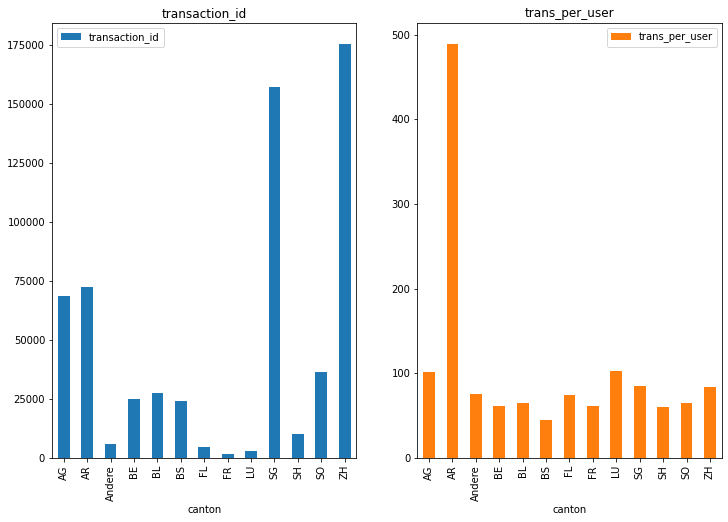

In [3]:
def activity_per(colname):
    
    users_per = users[['user_id', colname]]
    size_per = users_per.pivot_table(index=colname, values=['user_id'], aggfunc='nunique').reset_index()
    
    activity_per = transactions.merge(users_per, on='user_id', how='left')
    transactions_per = activity_per.pivot_table(index=colname, 
                                                values=['transaction_id', 'user_id'], 
                                                aggfunc={'transaction_id':'count', 'user_id':'nunique'}).reset_index()
    transactions_per['trans_per_user'] = transactions_per['transaction_id']/transactions_per['user_id']
    
    return users_per, size_per, transactions_per 



users_canton, canton_size, canton_transactions = activity_per('canton')
ax = canton_transactions.plot.bar(x='canton', 
                                  y=['transaction_id', 'trans_per_user'], 
                                  subplots=True, 
                                  layout=(1,2),
                                  figsize=(12,8))

<AxesSubplot:xlabel='canton'>

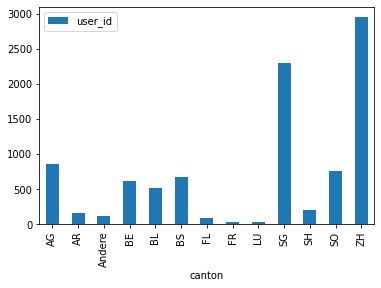

In [4]:
canton_size.plot.bar(x='canton', y='user_id')

These bar plots show us that cantons with greater numbers of students have a larger transaction count **overall**. However, most cantons, with the exception of AR show similar numbers of transactions *per user*.  

#### What's going on in AR?

,user_id,gender,canton,class_level,class_code


<AxesSubplot:xlabel='class_level'>

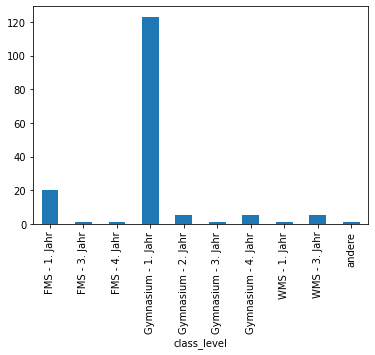

In [5]:
AR_users = users[users['canton'] == 'AR']
display(AR_users[~AR_users['class_code'].isnull()].head()) #none of the students here have a special class code

AR_levels = AR_users.groupby('class_level').count()['user_id']
AR_levels.plot.bar(x='class_level', y='user_id')

The vast majority of students in AR who use the app are in Gymansium - 1. Jahr which is the most represented year group. This might explain the high numbers of transactions per user. 

### Class (level) representation in the data set

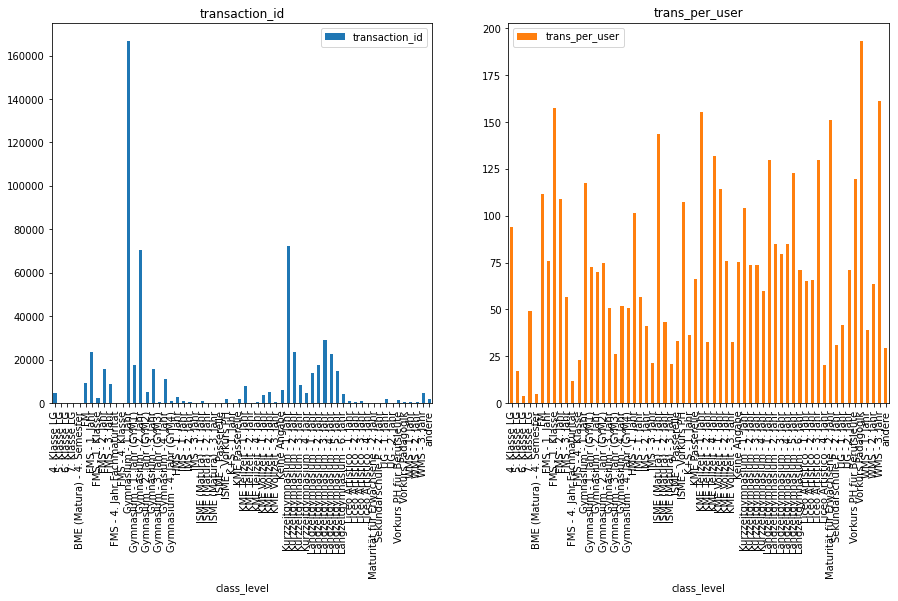

In [6]:
users_class, class_size, class_transactions = activity_per('class_level')

ax = class_transactions.plot.bar(x='class_level', 
                                 y=['transaction_id', 'trans_per_user'], 
                                 subplots=True, 
                                 layout=(1,2),
                                 figsize=(15,7)) #lots and lots of classes

In [7]:
#outliers 
def show_outliers(df, colname, method):
    
    if method == 'IQR':
        q1 = df[colname].quantile(0.25)
        q3 = df[colname].quantile(0.75)
        iqr = q3-q1
        lb = q1 - 1.5*iqr
        ub = q3 + 1.5*iqr
        
        print(f"Lower bound: {lb}")
        print(f"Upper bound: {ub}")
        
        out = df[(df[colname] < lb) | (df[colname] > ub)]
        
        return out
        
    if method == 'std':
        mean = df[colname].mean()
        std = df[colname].std()
        lb = mean - 2*std
        ub = mean + 2*std
        
        print(f"Lower bound: {lb}")
        print(f"Upper bound: {ub}")
        out = df[(df[colname] < lb) | (df[colname] > ub)]
        
        return out 

Lower bound: -188.75
Upper bound: 333.25


,class_level,user_id
6,FMS - 1. Jahr,379
13,Gymnasium - 1. Jahr,1852
14,Gymnasium - 1. Jahr (GYM1),336
15,Gymnasium - 2. Jahr,1179
17,Gymnasium - 3. Jahr,394
39,Kurzzeitgymnasium - 1. Jahr,945
40,Kurzzeitgymnasium - 2. Jahr,427
45,Langzeitgymnasium - 3. Jahr,481
46,Langzeitgymnasium - 4. Jahr,344


<AxesSubplot:>

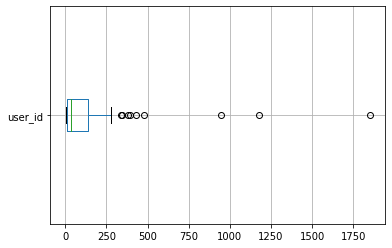

In [8]:
display(show_outliers(class_size, 'user_id', 'IQR'))
class_size.boxplot(column='user_id', vert=False)

Notice that the typical definition(s) for outliers do not exclude any classes at the lower end of the spectrum because there are many more classes with fewer numbers than higher ones. Therefore we will have to make a more precise and informed decision here. Of course classes with only one student (for example) will be poorly represented in the data set, therefore it would make sense to either group these students or remove them. 

In [9]:
display(show_outliers(class_transactions, 'transaction_id', 'IQR'))
display(show_outliers(class_transactions, 'trans_per_user', 'IQR')) #no outliers 

Lower bound: -12477.375
Upper bound: 21619.625


,class_level,transaction_id,user_id,trans_per_user
6,FMS - 1. Jahr,23387,309,75.686084
12,Gymnasium - 1. Jahr,166834,1423,117.241040
14,Gymnasium - 2. Jahr,70635,1007,70.143992
38,Kurzzeitgymnasium - 1. Jahr,72257,693,104.266955
39,Kurzzeitgymnasium - 2. Jahr,23574,320,73.668750
44,Langzeitgymnasium - 3. Jahr,29109,365,79.750685
45,Langzeitgymnasium - 4. Jahr,22488,265,84.860377


Lower bound: -60.78531043099058
Upper bound: 206.97796836537646


,class_level,transaction_id,user_id,trans_per_user


We note that these outliers are all extremes in the right hand tail of the distribution.

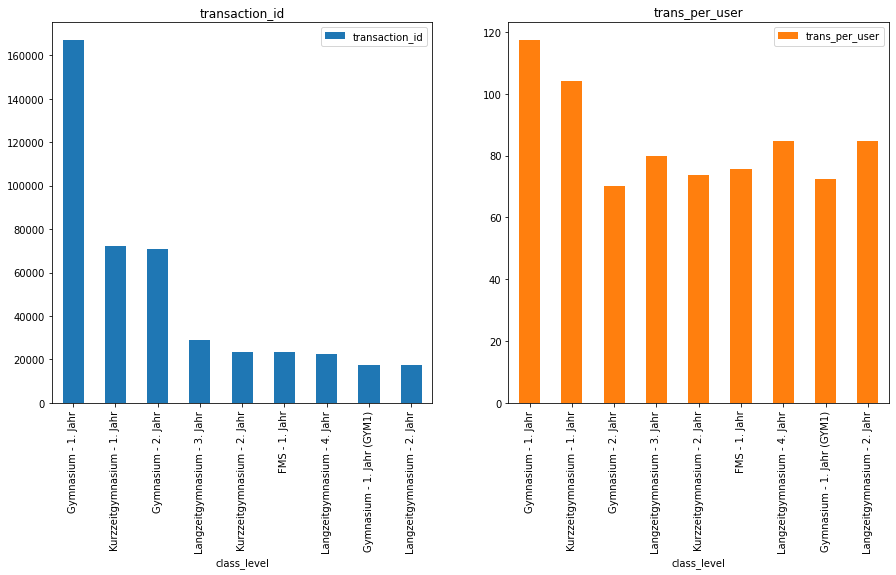

In [10]:
ax = class_transactions.sort_values(by=['transaction_id', 'trans_per_user'], 
                                    ascending=[False, False]) \
                        .iloc[0:9, :] \
                        .plot.bar(x='class_level',
                                  y=['transaction_id', 'trans_per_user'],
                                  subplots=True,
                                  layout=(1,2),
                                  figsize=(15,7))

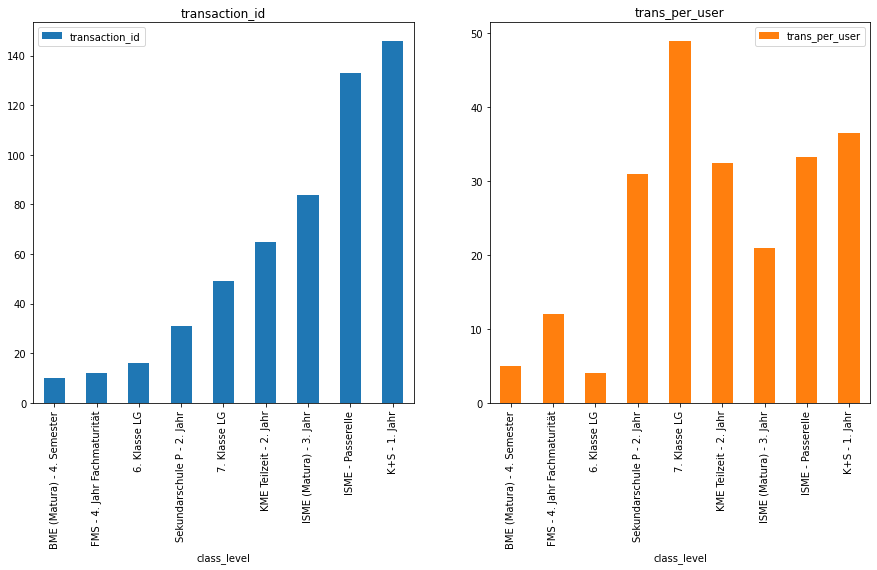

In [11]:
ax = class_transactions.sort_values(by=['transaction_id', 'trans_per_user'], 
                                    ascending=[True, True]) \
                        .iloc[0:9, :] \
                        .plot.bar(x='class_level',
                                  y=['transaction_id', 'trans_per_user'],
                                  subplots=True,
                                  layout=(1,2),
                                  figsize=(15,7))

### Level Check Usage

In [12]:
lst.drop('user_id', axis=1, inplace=True)

In [13]:
lst.head()

,learn_session_id,transaction_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted
0,6673,393831,3,5,1,1,1.0
1,6673,400408,3,5,1,1,1.0
2,6673,400409,3,5,1,1,1.0
3,6673,400410,3,5,1,1,1.0
4,6673,400411,3,5,1,1,1.0


In [14]:
tran_lst = transactions.merge(lst, on='transaction_id', how='inner')
tran_lst.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type,learn_session_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,SKIP,NaN,NaN,111059,3250,5,0,1,NaN
1,563378,b5978bb1-c34f-4157-9d1f-052b451edab5,387604.0,1aRVNzqunJs6eJCo9vZiy3,70675,NaN,NaN,1615192571101,NaN,unknown,NaN,NaN,NaN,14120,3,5,1,1,1.0
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,NaN,NaN,NaN,70380,3,5,1,2,NaN
3,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,SKIP,NaN,NaN,41166,3119,5,1,1,1.0
4,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,NaN,NaN,NaN,44450,3119,5,1,2,NaN


To add: distribution of level checks per student. Also, when are students doing level checks? Just after learn sessions perhaps? As in, how are they using them?

In [17]:
tran_lst_user = tran_lst[tran_lst['type_id'] == 2].groupby(['user_id', 'learn_session_id']).count()['type_id']
display(tran_lst_user) 

user_id   learn_session_id
387604.0  41319               4
          44450               1
          49468               1
          49471               1
          70380               1
                             ..
404597.0  111985              1
404599.0  111987              1
          111988              1
          111990              1
404604.0  112060              8
Name: type_id, Length: 27429, dtype: int64

Here we see that some `learn_session_id`s count more than one level check, so I'm assuming this means you can do more than one level check per session.  

Text(0.5, 1.0, 'Dist of level checks attempted per student')

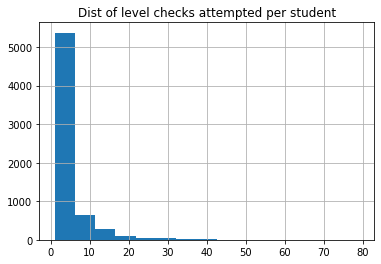

In [25]:
lst_user = tran_lst_user.reset_index().drop('learn_session_id', axis=1).groupby('user_id').count()
#display(lst_user)
lst_user.hist(bins=15)
plt.title('Dist of level checks attempted per student')

First we note that the data set records level checks even if they are incomplete, and as I have taken no steps to take account of this in the plot above, we can only say that these are attempts at level checks. It seems the vast majority of students do not do that many level checks. 

## Task 2: Model Building

Train a model for your research question. 

In [ ]:
# Your code for training a model goes here

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [ ]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*